In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score,roc_auc_score

import scikitplot as skplt
import matplotlib.pyplot as plt

In [ ]:
# AZURE EMBEDDINGS
data = pd.read_csv("../2.Feature extraction/embeddings/Azure_text-similarity-ada-002_embeddings.csv", index_col=0)
data.head(2)

# OPENAI EMBEDDINGS
# data = pd.read_csv("../2.Feature extraction/embeddings/OpenAI_text-similarity-ada-002_embeddings.csv.csv", index_col=0)
# data.head(2)

### 1.Preprocesing features

In [4]:
# Choose asr preprocess type to use
embedding_to_use = "embedding_cleaned_asr"
embeddings = ["embedding_asr","embedding_cleaned_asr","embedding_cleaned_asr_without_stopw"]
embeddings.remove(embedding_to_use)
data = data.drop(columns=embeddings, axis = 1)

In [6]:
# Suffix column
def get_suffix_from_intent(intent: str) -> str:
    return intent.split("-")[-1].strip()
data["suffix"] = data.intent.apply(lambda x: get_suffix_from_intent(x))

In [7]:
# Embeddings
data["embedding"] = data[embedding_to_use].apply(eval).apply(np.array)
tags = data['embedding'].apply(pd.Series)
features = tags.rename(columns = lambda x : 'embedding_feature_' + str(x))
result = pd.concat([data, features], axis=1)
df = result.drop(columns=["embedding"], axis=1)

### 2.Create X and y

In [9]:
# Create sets
X = df.drop(columns=["label"], axis = 1)
y = df["label"]

In [9]:
# Label encoding -> no open(0), open(1)
le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y)
print(list(le.classes_)) 
display(y_encoded)

['no open', 'open']


array([0, 1, 1, ..., 0, 0, 0])

In [10]:
# Extract text features -> convert to category
cats = X.select_dtypes(exclude=np.number).columns.tolist()
# Convert to Pandas category
for col in cats:
    X[col] = X[col].astype('category')

In [11]:
X.dtypes

asr_len                      int64
flow                      category
suffix                    category
embedding_feature_0        float64
embedding_feature_1        float64
                            ...   
embedding_feature_1531     float64
embedding_feature_1532     float64
embedding_feature_1533     float64
embedding_feature_1534     float64
embedding_feature_1535     float64
Length: 1539, dtype: object

In [12]:
# Divide data in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1)

In [13]:
print ("The training dataset has %i rows." % len(X_train))
print ("The first training dataset has %i no open asr." % ((y_train== 0).sum()))
print ("The first training dataset has %i open asr." % ((y_train == 1).sum()))

The training dataset has 1028 rows.
The first training dataset has 491 no open asr.
The first training dataset has 537 open asr.


In [14]:
# Convert dataset into DMatrix
xg_train = xgb.DMatrix(X_train, label=y_train,enable_categorical=True)
xg_test = xgb.DMatrix(X_test, label=y_test,enable_categorical=True)

### 3.Train Model

In [15]:
model = XGBClassifier(
    objective= 'binary:logistic',
    tree_method= "hist",
    nthread=4,enable_categorical=True,
    subsample=0.8,
    colsample_bytree=0.8
)

# Parameters to validate
parameters = {
    'max_depth': range (2, 10, 2),
    'n_estimators': range(60, 220, 80),
    'learning_rate': [0.15, 0.1, 0.01, 0.05]
}

clf = GridSearchCV(model, parameters, n_jobs=-1, scoring='balanced_accuracy', verbose=2, refit=True)
clf.fit(X_train, y_train)

# Best parameters
best_parameter = clf.best_params_ 
best_score = clf.best_score_ 
best_estimator = clf.best_estimator_

print(best_score)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[CV] END ...learning_rate=0.15, max_depth=2, n_estimators=60; total time=  37.8s
[CV] END ...learning_rate=0.15, max_depth=2, n_estimators=60; total time=  41.1s
[CV] END ...learning_rate=0.15, max_depth=2, n_estimators=60; total time=  43.7s
[CV] END ...learning_rate=0.15, max_depth=2, n_estimators=60; total time=  45.1s
[CV] END ...learning_rate=0.15, max_depth=2, n_estimators=60; total time=  46.7s
[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=140; total time= 1.5min
[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=140; total time= 1.7min[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=140; total time= 1.7min

[CV] END ...learning_rate=0.15, max_depth=4, n_estimators=60; total time= 1.1min
[CV] END ...learning_rate=0.15, max_depth=4, n_estimators=60; total time= 1.1min
[CV] END ...learning_rate=0.15, max_depth=4, n_estimators=60; total time= 1.2min
[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=140; total time= 1.6min
[CV] END ..learning_rate=0.1

In [16]:
print(best_parameter)

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 140}


In [17]:
print(best_estimator)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)


In [18]:
from joblib import dump, load

dump(clf, "xgboost_model_8.joblib")

['xgboost_model_8.joblib']

### 4.Predict

Some experiments results.

#### Experiment 3: OpenAI Embeddings with ADA1 model and preprocessed text with stopwords

In [19]:
estimator_model_3 = load("xgboost_model_3.joblib")

y_pred = estimator_model_3.predict(X_test)
y_proba = estimator_model_3.predict_proba(X_test)

print('Test Accuracy : %.2f'%accuracy_score(y_test,y_pred))
print('Test Precision : %.2f'%precision_score(y_test,y_pred))
print('Test Recall : %.2f'%recall_score(y_test,y_pred))
print('Test F1 Score : %.2f'%f1_score(y_test,y_pred))

# use the probability of positive class
mean_auc = roc_auc_score(y_test, y_proba[:,1], average="weighted")
print(f"Mean ROC-AUC = {mean_auc:.3f}")

print('\nConfusion Matrix : ')
print(confusion_matrix(y_test,y_pred))

print('\nClassification Report : ')
print(classification_report(y_test,y_pred))

Test Accuracy : 0.84
Test Precision : 0.84
Test Recall : 0.89
Test F1 Score : 0.87
Mean ROC-AUC = 0.907

Confusion Matrix : 
[[39 11]
 [ 7 58]]

Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.78      0.81        50
           1       0.84      0.89      0.87        65

    accuracy                           0.84       115
   macro avg       0.84      0.84      0.84       115
weighted avg       0.84      0.84      0.84       115



/home/andrea/Desktop/detect-open-responses/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


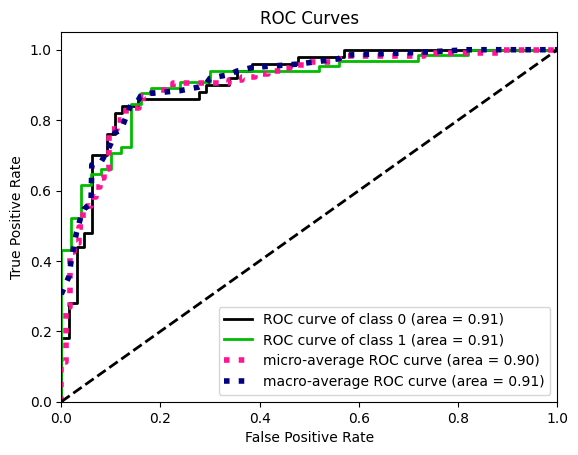

In [20]:
# ROC Curves
skplt.metrics.plot_roc_curve(y_test, y_proba)
plt.show()

#### Experiment 7: OpenAI Embeddings with ADA-2 model and not preprocessed text

In [22]:
estimator_model_7 = load("xgboost_model_7.joblib")
print(estimator_model_7)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bi...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan

In [23]:
y_pred = estimator_model_7.predict(X_test)
y_proba = estimator_model_7.predict_proba(X_test)

print('Test Accuracy : %.2f'%accuracy_score(y_test,y_pred))
print('Test Precision : %.2f'%precision_score(y_test,y_pred))
print('Test Recall : %.2f'%recall_score(y_test,y_pred))
print('Test F1 Score : %.2f'%f1_score(y_test,y_pred))

# use the probability of positive class
mean_auc = roc_auc_score(y_test, y_proba[:,1], average="weighted")
print(f"Mean ROC-AUC = {mean_auc:.3f}")

print('\nConfusion Matrix : ')
print(confusion_matrix(y_test,y_pred))

print('\nClassification Report : ')
print(classification_report(y_test,y_pred))

Test Accuracy : 0.78
Test Precision : 0.79
Test Recall : 0.83
Test F1 Score : 0.81
Mean ROC-AUC = 0.844

Confusion Matrix : 
[[38 14]
 [11 52]]

Classification Report : 
              precision    recall  f1-score   support

           0       0.78      0.73      0.75        52
           1       0.79      0.83      0.81        63

    accuracy                           0.78       115
   macro avg       0.78      0.78      0.78       115
weighted avg       0.78      0.78      0.78       115



/home/andrea/Desktop/detect_open_responses/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


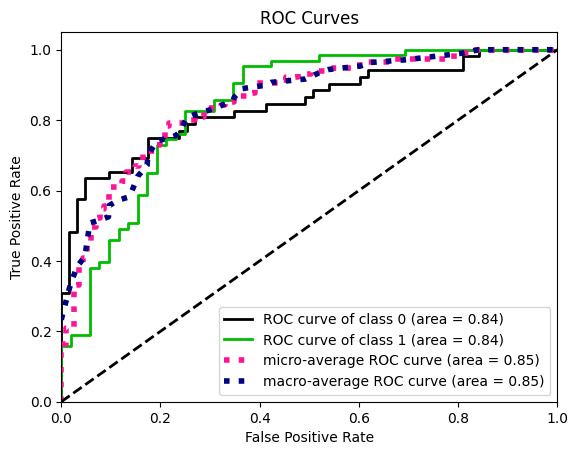

In [24]:
# ROC Curves
skplt.metrics.plot_roc_curve(y_test, y_proba)
plt.show()

#### Experiment 9: OpenAI Embeddings with ADA-2 model and cleaned text with stopwords

In [28]:
estimator_model_9 = load("models/xgboost_model_9.joblib")
print(estimator_model_9)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bi...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan

In [29]:
y_pred = estimator_model_9.predict(X_test)
y_proba = estimator_model_9.predict_proba(X_test)

print('Test Accuracy : %.2f'%accuracy_score(y_test,y_pred))
print('Test Precision : %.2f'%precision_score(y_test,y_pred))
print('Test Recall : %.2f'%recall_score(y_test,y_pred))
print('Test F1 Score : %.2f'%f1_score(y_test,y_pred))

# use the probability of positive class
mean_auc = roc_auc_score(y_test, y_proba[:,1], average="weighted")
print(f"Mean ROC-AUC = {mean_auc:.3f}")

print('\nConfusion Matrix : ')
print(confusion_matrix(y_test,y_pred))

print('\nClassification Report : ')
print(classification_report(y_test,y_pred))

Test Accuracy : 0.82
Test Precision : 0.83
Test Recall : 0.84
Test F1 Score : 0.83
Mean ROC-AUC = 0.867

Confusion Matrix : 
[[42 11]
 [10 52]]

Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        53
           1       0.83      0.84      0.83        62

    accuracy                           0.82       115
   macro avg       0.82      0.82      0.82       115
weighted avg       0.82      0.82      0.82       115



/home/andrea/Desktop/detect_open_responses/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


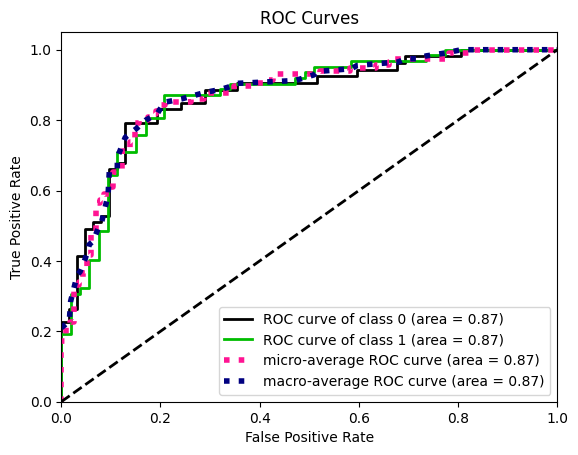

In [30]:
# ROC Curves
skplt.metrics.plot_roc_curve(y_test, y_proba)
plt.show()

#### Experiment 10: Azure Embeddings with ADA2 model and preprocessed asr with stopwords

In [20]:
estimator_model_10 = load("xgboost_model_10.joblib")

y_pred = estimator_model_10.predict(X_test)
y_proba = estimator_model_10.predict_proba(X_test)

print('Test Accuracy : %.2f'%accuracy_score(y_test,y_pred))
print('Test Precision : %.2f'%precision_score(y_test,y_pred))
print('Test Recall : %.2f'%recall_score(y_test,y_pred))
print('Test F1 Score : %.2f'%f1_score(y_test,y_pred))

# use the probability of positive class
mean_auc = roc_auc_score(y_test, y_proba[:,1], average="weighted")
print(f"Mean ROC-AUC = {mean_auc:.3f}")

print('\nConfusion Matrix : ')
print(confusion_matrix(y_test,y_pred))

print('\nClassification Report : ')
print(classification_report(y_test,y_pred))

Test Accuracy : 0.84
Test Precision : 0.84
Test Recall : 0.89
Test F1 Score : 0.87
Mean ROC-AUC = 0.899

Confusion Matrix : 
[[38 11]
 [ 7 59]]

Classification Report : 
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        49
           1       0.84      0.89      0.87        66

    accuracy                           0.84       115
   macro avg       0.84      0.83      0.84       115
weighted avg       0.84      0.84      0.84       115



/home/andrea/Desktop/detect-open-responses/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


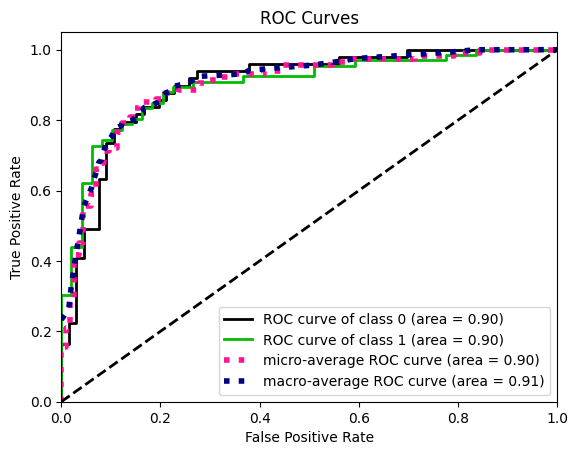

In [21]:
# ROC Curves
skplt.metrics.plot_roc_curve(y_test, y_proba)
plt.show()